# Modelo de Bateria

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
from battery_utils import v_mid, v_inf, v_sup, cs_r0, cs_r1, cs_r2, cs_c1, cs_c2

## Execução

### Componentes e OVC em função do SoC

In [2]:
cs_mid = v_mid()

def OCV(z):
    if z<0.05:
        return 0
    if z>1:
        return 3.5
    return cs_mid(z)

def r0(ocv):
    if ocv>3.343:
        return cs_r0(3.343)

    if ocv<3.184:
        return cs_r0(3.184)

    return cs_r0(ocv)

def r1(ocv):
    if ocv>3.343:
        return cs_r1(3.343)

    if ocv<3.184:
        return cs_r1(3.184)

    return cs_r1(ocv)

def c1(ocv):
    if ocv>3.343:
        return cs_c1(3.343)

    if ocv<3.184:
        return cs_c1(3.184)

    return cs_c1(ocv)

def r2(ocv):
    if ocv>3.343:
        return cs_r2(3.343)

    if ocv<3.184:
        return cs_r2(3.184)

    return cs_r2(ocv)

def c2(ocv):
    if ocv>3.343:
        return cs_c2(3.343)

    if ocv<3.184:
        return cs_c2(3.184)

    return cs_c2(ocv)


### Update dos valores

In [3]:
def update_z(z, Q, n, i, d_t):
    '''
    z: SoC
    Q: capacidade total (As)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (s)
    '''
    d_h = d_t/3600
    z -= n*i*(d_h/Q)
    return max(z,0)

In [4]:
def update_v(z, i_r0, i_r1, i_r2=0):
    ocv = OCV(z)
    return ocv - i_r0*r0(ocv) - i_r1*r1(ocv) - i_r2*r2(ocv)

In [5]:
#d_t em segundos nessa equação
def update_i_r1(ocv, i_r0, i_r1, d_t):
    e = np.exp(-d_t/(c1(ocv)*r1(ocv)))
    return i_r1*e+i_r0*(1-e)

def update_i_r2(ocv, i_r0, i_r2, d_t):
    e = np.exp(-d_t/(c1(ocv)*r2(ocv)))
    return i_r2*e+i_r0*(1-e)

### Loop de execução

In [12]:
z = 1 # SoC
Q = 100 # capacidade total (Ah) (100Ah)
d_t = 0.01 # variação no tempo (s)
n = 1 # eficiência coulombiana/carga
i_r1 = 0 # corrente (A)
i_r2 = 0 # corrente (A)
i0 = 100 # corrente (A)

V = []
I1 = []
Z = []
pausa = int(3600/d_t)
descarga = int(pausa*0.1)
I0 = ([0.0]*pausa+[i0]*descarga)*9 # corrente (A)

for i_r0 in I0:
    if z <= 0:
        I0 = I0[:len(V)]
        break
    # Update dos valores
    v = update_v(z, i_r0, i_r1, i_r2)
    z = update_z(z, Q, n, i_r0, d_t)

    ocv = OCV(z)
    i_r1 = update_i_r1(ocv, i_r0, i_r1, d_t)
    i_r2 = update_i_r2(ocv, i_r0, i_r2, d_t)
    # Armazenamento dos valores
    V.append(v)
    Z.append(z)
    I1.append(i_r1)

t = np.arange(len(V))
df = ps.DataFrame(data={'t':t,'V': V, 'I0': I0, 'Z': Z})
df['dV'] = df['V'].diff()
df['dI'] = df['I0'].diff()

### Gráficos

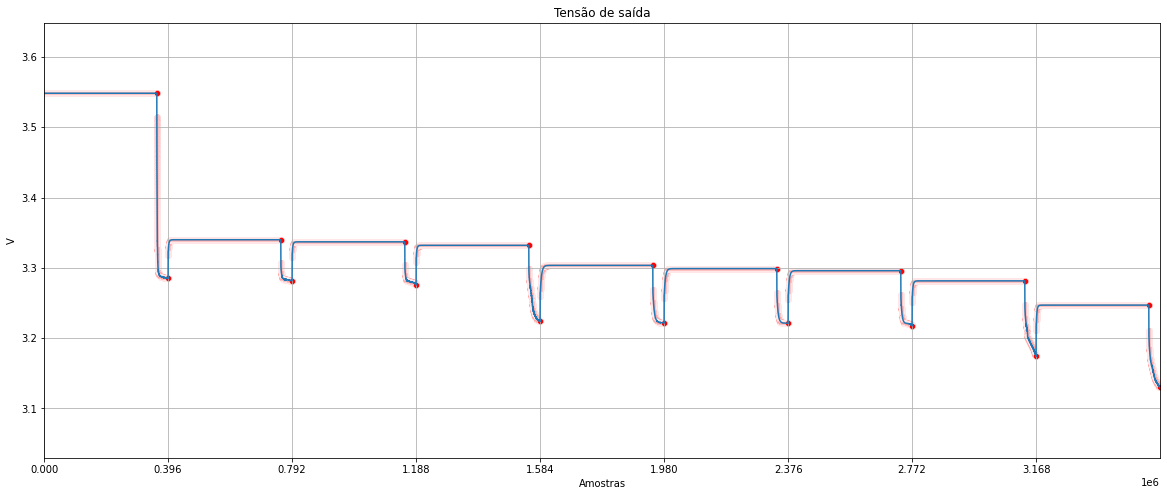

In [13]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df.to_pandas(), x='t', y='V')
sns.scatterplot(data=df.to_pandas(), x='t', y='V', color='red')
plt.ylabel('V')
plt.xlabel('Amostras')
plt.title('Tensão de saída')
plt.ylim([min(V)-0.1, max(V)+0.1])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), pausa+descarga))
plt.grid()
plt.show()
plt.close()